In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

%load_ext autoreload
%autoreload 2

# STATS 370
## Final project

In [3]:
from plot_utils import plot_dist, plot_marginals, plot_acorr, set_plt_settings
from dist_utils import prob_post, value_mh_cand, prob_mh_cand
from dist_utils import val_gibbs_ss, val_gibbs_tau, val_gibbs_mu, val_gibbs_gam
from dist_utils import prob_HMC
from mc_utils import MH, leapfrog, HMC

set_plt_settings()

In [4]:
# read in data
data = np.genfromtxt('data.csv', delimiter=',', skip_header=1, usecols=(1,2,3))
groups = torch.tensor(data[:,0].astype(int))
Y = torch.tensor(data[:, 1:], requires_grad=True)

## Metropolis Hasting
### Grid search for best hyperparameters

In [6]:
# grid search
# vary variances of proposal distributions to i) increase acceptance probability and ii) decrease acorr
x0 = torch.tensor([0.25, 0.5, -1, -1, 0, 0])
T = 1000
burn_in = 100
acorr_threshold = 0.3
report = {}
best_accept_mh = 0.0 

vmgs = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
vts = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
vsss = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
best_params_mh = (vmgs[0], vts[0], vsss[0])

# search hyperparameter space
for vmg in tqdm(vmgs):
    for vt in vts:
        for vss in vsss:
            # run MH
            xt, cands, status = MH(x=x0, Y=Y, groups=groups, var_mg=vmg, var_t=vt, var_ss=vss, T=T, verbose=False)
            # get and log stats
            pct_accept = np.sum(status[burn_in:] == 'a') / len(status)
            lags = np.apply_along_axis(sm.tsa.acf, axis=0, arr=xt, nlags=T/2)
            steps = np.argmin(np.abs(lags - acorr_threshold), axis=0).tolist()
            report[vss, vt, vmg] = [pct_accept] + steps
            
            # remember best
            if pct_accept > best_accept_mh:
                best_accept_mh = pct_accept
                best_params_mh = (vmg, vt, vss)

print('best parameters (var mu/gam, var tau, var ss):', best_params_mh)

 17%|███████▌                                     | 1/6 [01:23<06:57, 83.51s/it]


KeyboardInterrupt: 

### Run with selected hyperparameters for the proposal distribution

In [46]:
x0 = torch.tensor([0.25, 0.5, -1, -1, 0, 0])
T = 10000
vmg, vt, vss = best_params_mh

xt_mh, cands_mh, status_mh = MH(x=x0, Y=Y, groups=groups, var_mg=vmg, var_t=vt, var_ss=vss, T=T)

100%|████████████████████████████████████| 10000/10000 [00:21<00:00, 464.66it/s]


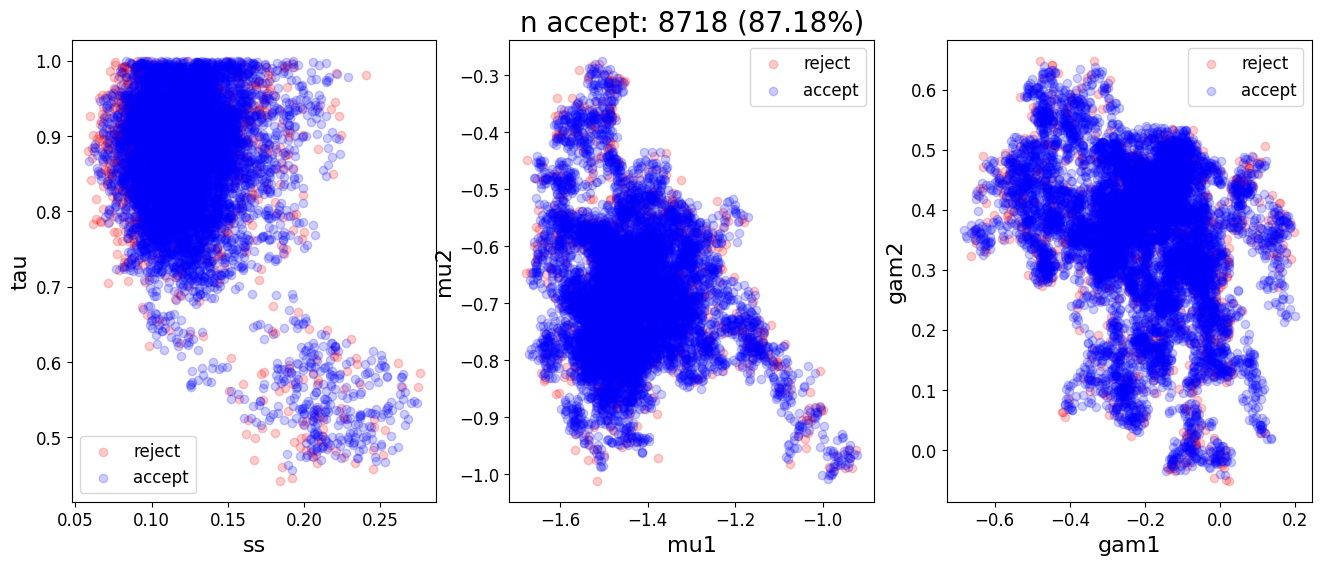

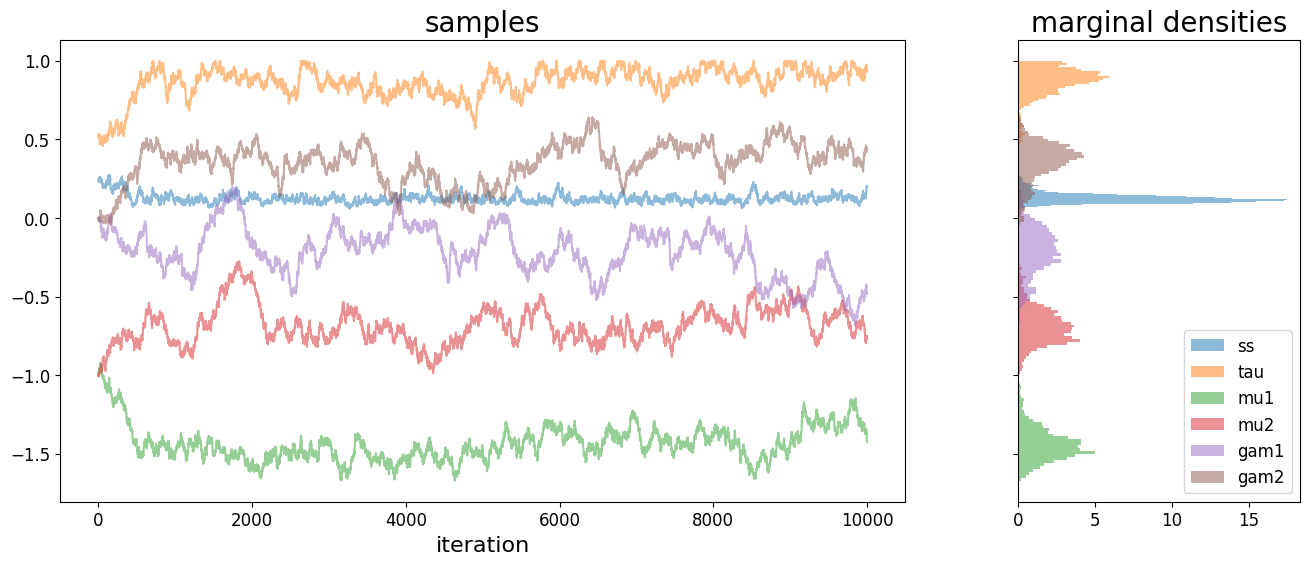

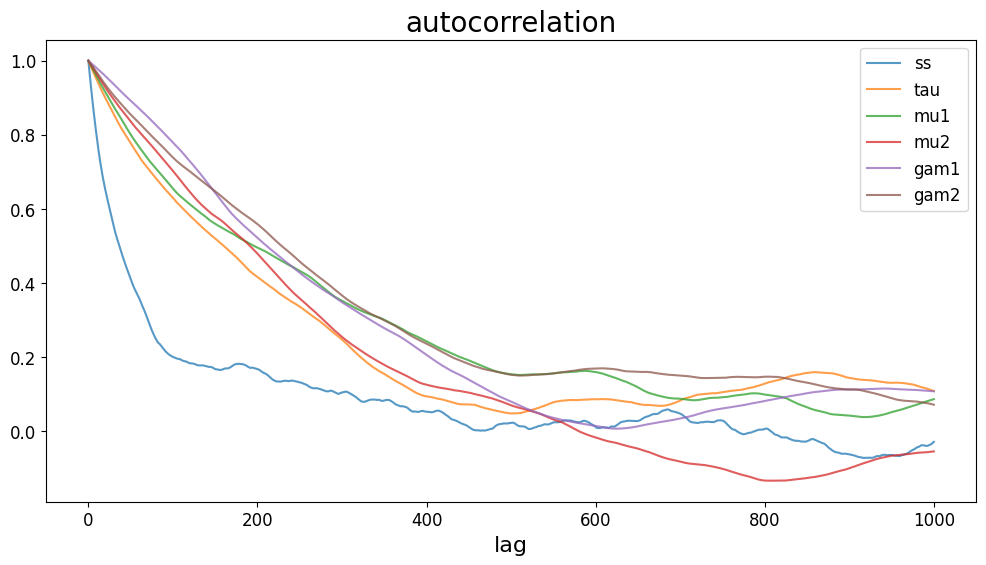

In [47]:
plot_dist(cands_mh, plot_status=True, status=status_mh)
plot_marginals(xt_mh)
plot_acorr(xt_mh, nlags=T/10)

In [91]:
theta_labels = ['ss', 'tau', 'mu1', 'mu2', 'gam1', 'gam2']

# read-out statistics
stats_mh = {}
stats_mh['mean'] = np.mean(xt_mh, axis=0)
stats_mh['var'] = np.var(xt_mh, axis=0)
stats_mh['median'] = np.median(xt_mh, axis=0)
for pctl in [0, 10, 25, 50, 75, 90, 100]:
    stats_mh[f'p{pctl}'] = np.percentile(xt_mh, pctl, axis=0)
stats_mh = pd.DataFrame(stats_mh).T
stats_mh.columns = theta_labels
print('univariate statistics')
display(stats_mh)

# covariance
cov_mh = pd.DataFrame(np.cov(xt_mh.T))
cov_mh.columns = theta_labels
cov_mh.index = theta_labels
print('covariance')
display(cov_mh)

univariate statistics


,ss,tau,mu1,mu2,gam1,gam2
mean,0.123902,0.864576,-1.436087,-0.686051,-0.215597,0.353686
var,0.000896,0.008965,0.012505,0.013822,0.024747,0.015874
median,0.118796,0.882236,-1.450212,-0.695737,-0.206009,0.377062
p0,0.059124,0.456525,-1.671236,-1.008609,-0.683261,-0.041705
p10,0.092982,0.758587,-1.559602,-0.815152,-0.451188,0.160858
p25,0.104076,0.822805,-1.508185,-0.770251,-0.307646,0.294027
p50,0.118796,0.882236,-1.450212,-0.695737,-0.206009,0.377062
p75,0.136506,0.927192,-1.382524,-0.613831,-0.105115,0.439852
p90,0.158412,0.965555,-1.301485,-0.543669,-0.028603,0.492153
p100,0.274064,0.999927,-0.921051,-0.274519,0.199335,0.639746


covariance


,ss,tau,mu1,mu2,gam1,gam2
ss,0.000896,-0.001075,0.001088,-0.000485,0.000358,-0.001115
tau,-0.001075,0.008966,-0.002086,0.004315,-0.002256,0.007118
mu1,0.001088,-0.002086,0.012506,-0.002707,-0.002846,-0.001776
mu2,-0.000485,0.004315,-0.002707,0.013823,0.000751,0.004686
gam1,0.000358,-0.002256,-0.002846,0.000751,0.024750,-0.006164
gam2,-0.001115,0.007118,-0.001776,0.004686,-0.006164,0.015875


## Gibs sampling

In [18]:
T = 10000
xt_g = []
continuous_scan = True
cond_dists = [val_gibbs_ss, val_gibbs_tau, val_gibbs_mu, val_gibbs_gam]

# Initialize then iterate
x0 = np.array((0.1, 0.75, np.array([0,0]), np.array([0,0])), dtype=object)
x = x0

for t in tqdm(range(T)):
    # sample iteratively from conditional distributions
    # determine scan
    if continuous_scan:
        update_idx = np.array(range(4))
    else:
        update_idx = np.random.choice(range(4), 4, replace=False)
    
    for j in update_idx:
        x[j] = cond_dists[j](x, Y.detach().numpy(), groups)
    
    # record in flattened state
    xt_g += [np.hstack(x)]

xt_g = np.array(xt_g)

100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1014.39it/s]


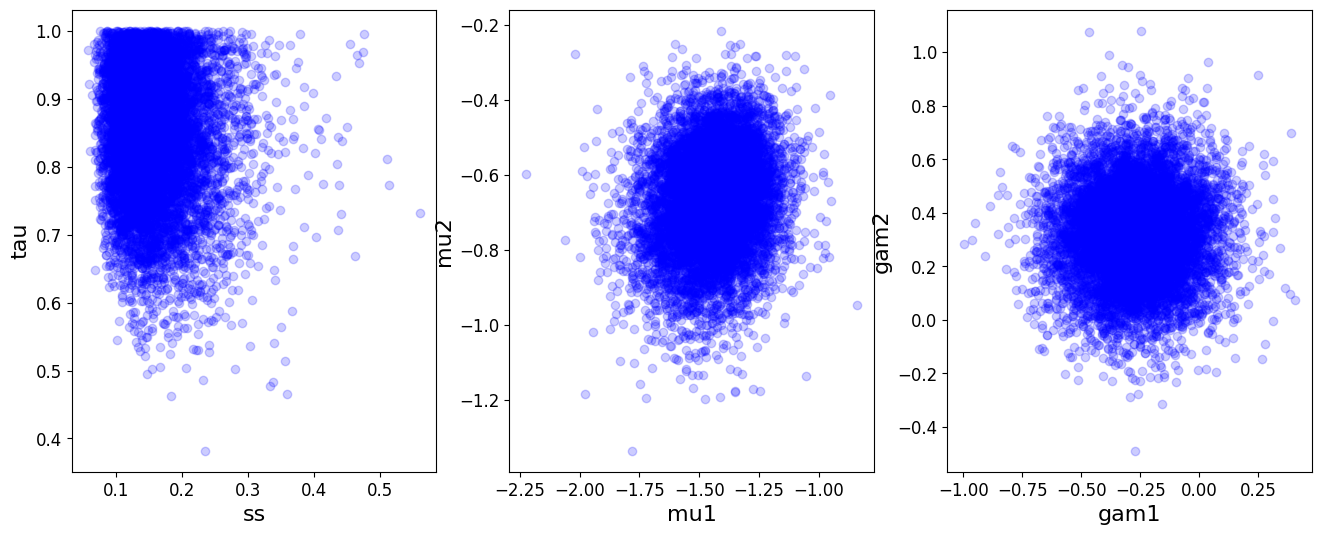

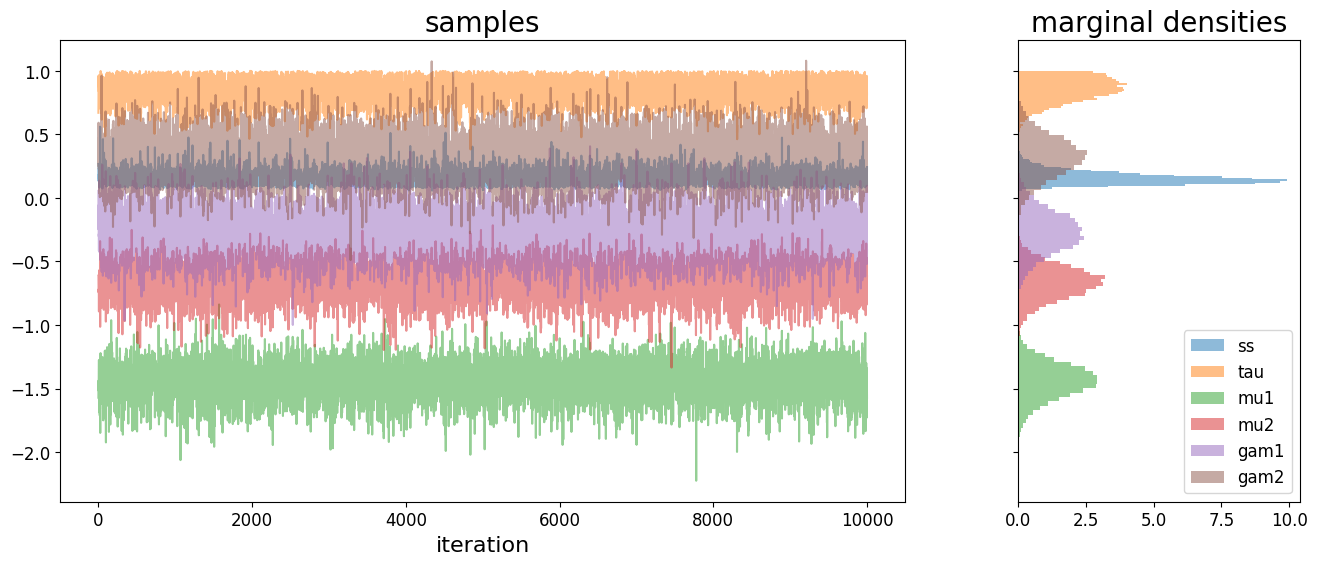

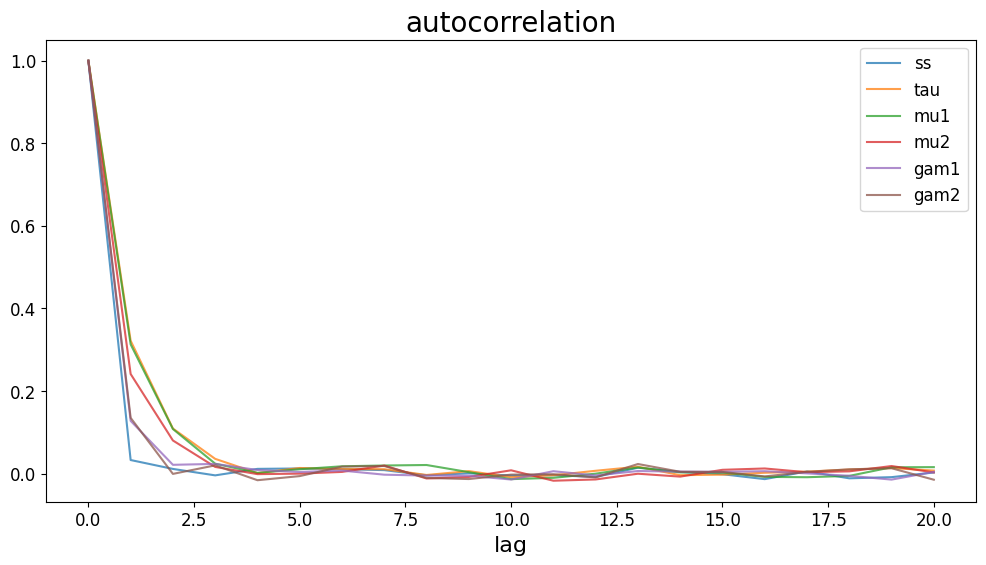

In [19]:
plot_dist(xt_g, plot_status=False)
plot_marginals(xt_g)
plot_acorr(xt_g, nlags=20)

In [90]:
theta_labels = ['ss', 'tau', 'mu1', 'mu2', 'gam1', 'gam2']

# read-out statistics
stats_g = {}
stats_g['mean'] = np.mean(xt_g, axis=0)
stats_g['var'] = np.var(xt_g, axis=0)
stats_g['median'] = np.median(xt_g, axis=0)
for pctl in [0, 10, 25, 50, 75, 90, 100]:
    stats_g[f'p{pctl}'] = np.percentile(xt_g, pctl, axis=0)
stats_g = pd.DataFrame(stats_g).T
stats_g.columns = theta_labels
print('univariate statistics')
display(stats_g)

# covariance
cov_g = pd.DataFrame(np.cov(xt_g.T))
cov_g.columns = theta_labels
cov_g.index = theta_labels
print('covariance')
display(cov_g)

univariate statistics


,ss,tau,mu1,mu2,gam1,gam2
mean,0.155838,0.849322,-1.441672,-0.667367,-0.270480,0.321592
var,0.002457,0.008747,0.019548,0.017039,0.028078,0.028000
median,0.146796,0.857843,-1.437134,-0.663447,-0.270875,0.323485
p0,0.057922,0.382010,-2.225287,-1.334650,-0.999112,-0.488752
p10,0.102991,0.720755,-1.620642,-0.831827,-0.482331,0.106645
p25,0.121184,0.787901,-1.527638,-0.752099,-0.378813,0.211788
p50,0.146796,0.857843,-1.437134,-0.663447,-0.270875,0.323485
p75,0.180152,0.923558,-1.348362,-0.578850,-0.159212,0.431277
p90,0.219189,0.967120,-1.270775,-0.505549,-0.060342,0.530755
p100,0.560857,0.999996,-0.838082,-0.215046,0.406444,1.080122


covariance


,ss,tau,mu1,mu2,gam1,gam2
ss,0.002457,-0.000427,-0.000348,-0.000180,0.000132,0.000056
tau,-0.000427,0.008748,0.005993,0.004066,-0.000412,0.000921
mu1,-0.000348,0.005993,0.019550,0.002897,-0.007446,0.000385
mu2,-0.000180,0.004066,0.002897,0.017041,-0.000255,-0.007426
gam1,0.000132,-0.000412,-0.007446,-0.000255,0.028081,0.000310
gam2,0.000056,0.000921,0.000385,-0.007426,0.000310,0.028003


## Hamiltonian Monte Carlo

### Grid search

In [13]:
# vary variances of proposal distributions to i) increase acceptance probability and ii) decrease acorr
q0 = torch.tensor([0.25, 0.5, -1, -1, 0, 0])
T = 300
burn_in = 0
acorr_threshold = 0.3
report = {}
best_accept_hmc = 0.0

# hyperparameter grid
M_rats = [
#     [1, 1, 1, 1, 1, 1],
#       [0.5, 1, 1, 1, 1, 1],
      [0.25, 0.5, 1, 1, 1, 1],
#       [0.25, 0.5, 1, 1, 0.75, 0.75]
]
M_scales = [1.25, 1.5, 1.75]
Ls = [15]
epss = [0.001, 0.005]
best_params_hmc = (M_rats[0], M_scales[0], Ls[0], epss[0])

# search hyperparameter space
for i, M_rat in enumerate(tqdm(M_rats, disable=False)):
    for M_scale in M_scales:
        M = M_scale*torch.diag(torch.tensor(M_rat, dtype=torch.float))
        M_inv = torch.linalg.inv(M)
        p0 = torch.tensor(sps.multivariate_normal.rvs(mean=np.repeat(0,len(q0)), cov=M)).float()
        for L in Ls:
            for eps in epss:
                # run MH
                qt, cands, status = HMC(q=q0, p=p0, Y=Y, groups=groups, M=M, M_inv=M_inv, eps=eps, L=L, T=T, verbose=False)
                # get and log stats
                pct_accept = np.sum(status[burn_in:] == 'a') / len(status)
                lags = np.apply_along_axis(sm.tsa.acf, axis=0, arr=qt, nlags=T/10)
                steps = np.argmin(np.abs(lags - acorr_threshold), axis=0).tolist()
                report[i, M_scale, L, eps] = [pct_accept] + steps
                
                # remember best
                if pct_accept > best_accept_hmc:
                    best_accept_hmc = pct_accept
                    best_params_hmc = (M_rat, M_scale, L, eps)

print('best parameters (Mrat, Mscale, L, eps):', best_params_hmc)

100%|█████████████████████████████████████████████| 1/1 [00:33<00:00, 33.67s/it]

best parameters (Mrat, Mscale, L, eps): ([0.25, 0.5, 1, 1, 1, 1], 1.25, 15, 0.001)


### Run with best hyperparams

In [18]:
T=10000
M_rat, M_scale, L, eps = best_params_hmc
M = M_scale*torch.diag(torch.tensor(M_rat, dtype=torch.float))
M_inv = torch.linalg.inv(M)

q0 = torch.tensor([0.25, 0.5, -1, -1, 0, 0], dtype=torch.float)
p0 = torch.tensor(sps.multivariate_normal.rvs(mean=np.repeat(0,len(q0)), cov=M)).float()

q_hmc, cands_hmc, status_hmc = HMC(q0, p0, Y, groups, M, M_inv, eps, L, T)

100%|█████████████████████████████████████| 10000/10000 [03:02<00:00, 54.92it/s]


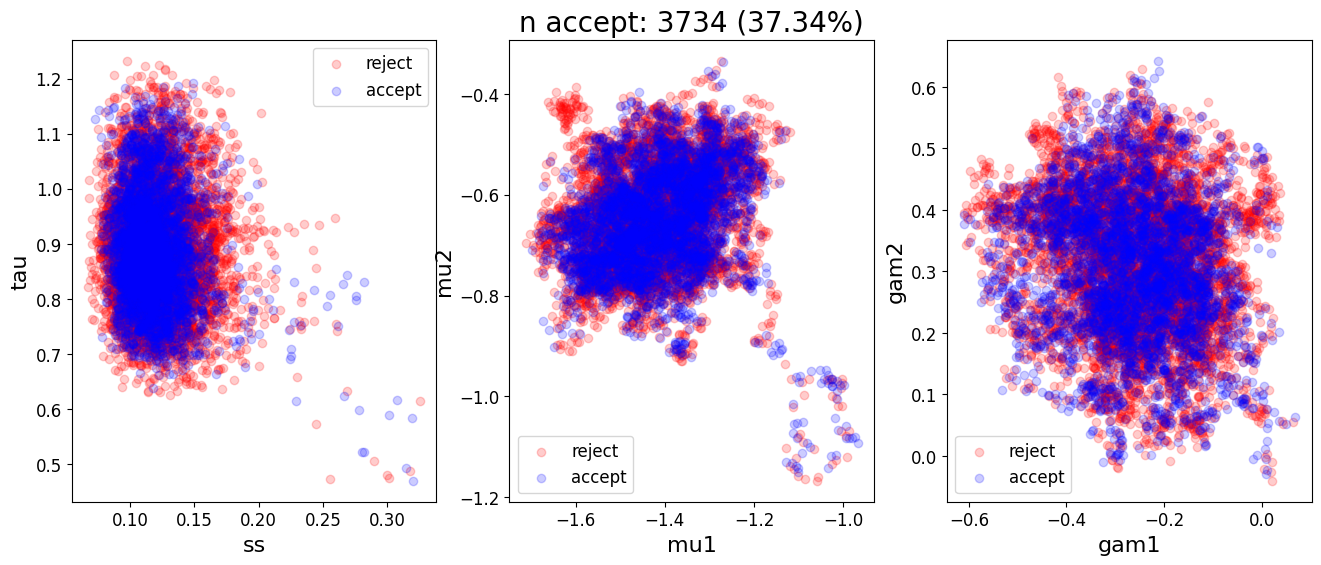

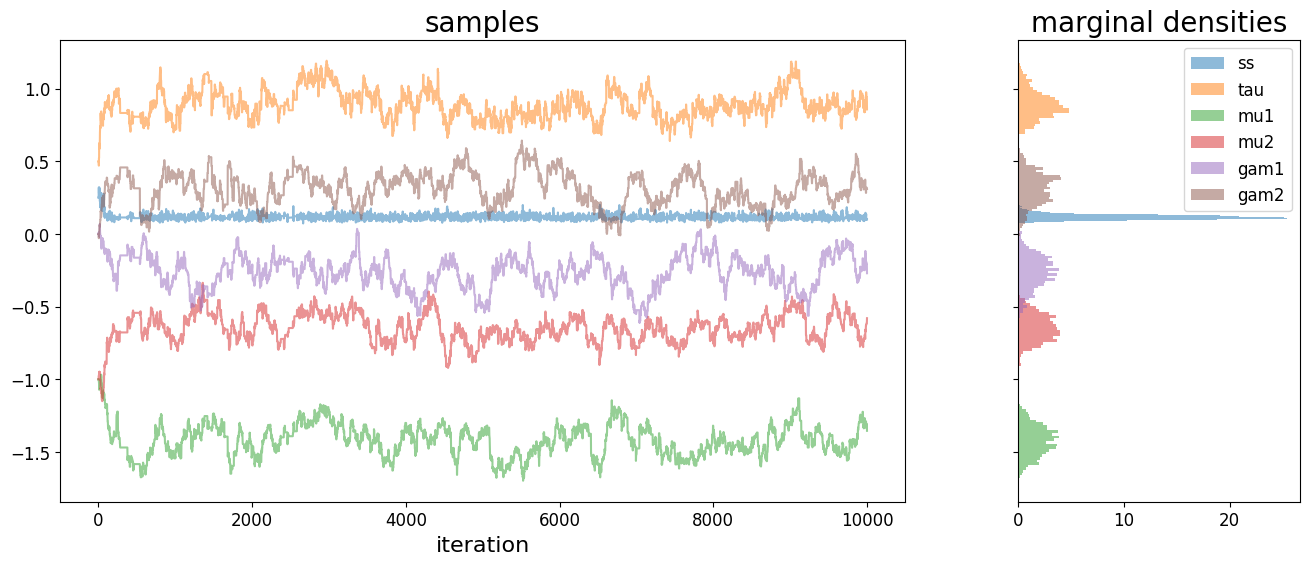

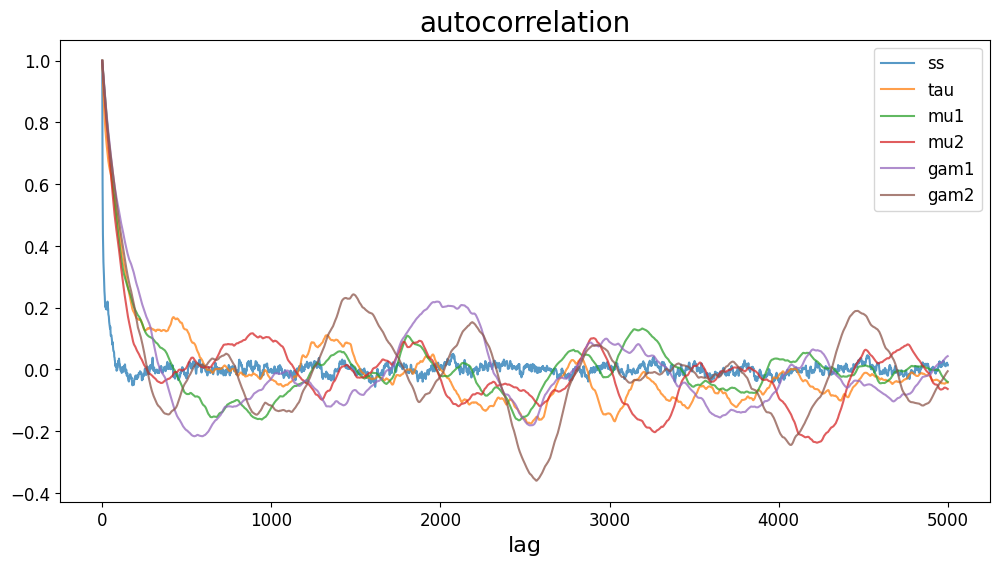

In [19]:
plot_dist(cands_hmc, plot_status=True, status=status_hmc)
plot_marginals(q_hmc)
plot_acorr(q_hmc)

In [20]:
theta_labels = ['ss', 'tau', 'mu1', 'mu2', 'gam1', 'gam2']

# read-out statistics
stats_hmc = {}
stats_hmc['mean'] = np.mean(q_hmc, axis=0)
stats_hmc['var'] = np.var(q_hmc, axis=0)
stats_hmc['median'] = np.median(q_hmc, axis=0)
for pctl in [0, 10, 25, 50, 75, 90, 100]:
    stats_hmc[f'p{pctl}'] = np.percentile(q_hmc, pctl, axis=0)
stats_hmc = pd.DataFrame(stats_hmc).T
stats_hmc.columns = theta_labels
print('univariate statistics')
display(stats_hmc)

# covariance
cov_hmc = pd.DataFrame(np.cov(q_hmc.T))
cov_hmc.columns = theta_labels
cov_hmc.index = theta_labels
print('covariance')
display(cov_hmc)

univariate statistics


,ss,tau,mu1,mu2,gam1,gam2
mean,0.117317,0.887769,-1.418118,-0.648483,-0.262349,0.311890
var,0.000392,0.009574,0.011668,0.009821,0.013335,0.012878
median,0.114561,0.879508,-1.416866,-0.648875,-0.255565,0.316136
p0,0.072502,0.470156,-1.697244,-1.149798,-0.609677,-0.028723
p10,0.097188,0.766148,-1.560136,-0.766889,-0.423226,0.164766
p25,0.104727,0.822252,-1.493697,-0.717267,-0.336918,0.232228
p50,0.114561,0.879508,-1.416866,-0.648875,-0.255565,0.316136
p75,0.126490,0.945281,-1.345538,-0.574919,-0.177077,0.393013
p90,0.139259,1.028261,-1.284349,-0.522899,-0.121731,0.457479
p100,0.320149,1.191853,-0.967700,-0.335576,0.068938,0.642744


covariance


,ss,tau,mu1,mu2,gam1,gam2
ss,0.000392,-0.000321,0.000213,-0.000436,0.000334,-0.000311
tau,-0.000321,0.009575,0.006117,0.005551,-0.002566,0.000254
mu1,0.000213,0.006117,0.011669,0.001501,-0.003341,-0.000699
mu2,-0.000436,0.005551,0.001501,0.009822,-0.001266,-0.001162
gam1,0.000334,-0.002566,-0.003341,-0.001266,0.013336,-0.001895
gam2,-0.000311,0.000254,-0.000699,-0.001162,-0.001895,0.012879
